In [11]:
import pyemma
import pickle
import os
import glob
import torch

import mdtraj as md
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt
import numpy as np

np.bool = np.bool_

from tqdm import tqdm
from matplotlib.colors import LogNorm
from itertools import combinations

blue = (70 / 255, 110 / 255, 250 / 255)
green = (100 / 255, 170 / 255, 120 / 255)

molecule = "1FME"
simulation_idx = 0
base_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-protein"
save_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein"
pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_from_mae.pdb"

# Strings

In [3]:
name2letter = {
	"ALA": "A",
	"CYS": "C",
	"ASP": "D",
	"GLU": "E",
	"PHE": "F",
	"GLY": "G",
	"HIS": "H",
	"ILE": "I",
	"LYS": "K",
	"LEU": "L",
	"MET": "M",
	"ASN": "N",
	"PRO": "P",
	"GLN": "Q",
	"ARG": "R",
	"SER": "S",
	"THR": "T",
	"VAL": "V",
	"TRP": "W",
	"TYR": "Y",
	"NLE": "X",
}

pdb_traj = md.load_pdb(pdb_path) 
residue_names = [residue.name for residue in pdb_traj.topology.residues]
one_letter_str = ""
for idx, names in enumerate(residue_names):
    # print(f"Letter {idx}: {name2letter[names]}")
    one_letter_str += name2letter[names]
print(one_letter_str)
print(len(one_letter_str))

EQYTAKYKGRTFRNEKELRDFIEKFKGR
28


In [4]:
# CA atom index
ca_atoms = [atom for atom in pdb_traj.topology.atoms if atom.name == "CA"]
ca_indices = [atom.index for atom in ca_atoms]

cnt = 1
for i in range(len(ca_indices)):
    for j in range(i+1, len(ca_indices)):
        print(f"d{cnt}: DISTANCE ATOMS={ca_indices[i]+1},{ca_indices[j]+1}")
        cnt += 1

print("ARG=" + ",".join(f"d{i+1}" for i in range(cnt)))

d1: DISTANCE ATOMS=5,20
d2: DISTANCE ATOMS=5,37
d3: DISTANCE ATOMS=5,58
d4: DISTANCE ATOMS=5,72
d5: DISTANCE ATOMS=5,82
d6: DISTANCE ATOMS=5,104
d7: DISTANCE ATOMS=5,125
d8: DISTANCE ATOMS=5,147
d9: DISTANCE ATOMS=5,154
d10: DISTANCE ATOMS=5,178
d11: DISTANCE ATOMS=5,192
d12: DISTANCE ATOMS=5,212
d13: DISTANCE ATOMS=5,236
d14: DISTANCE ATOMS=5,250
d15: DISTANCE ATOMS=5,265
d16: DISTANCE ATOMS=5,287
d17: DISTANCE ATOMS=5,302
d18: DISTANCE ATOMS=5,321
d19: DISTANCE ATOMS=5,345
d20: DISTANCE ATOMS=5,357
d21: DISTANCE ATOMS=5,377
d22: DISTANCE ATOMS=5,396
d23: DISTANCE ATOMS=5,411
d24: DISTANCE ATOMS=5,433
d25: DISTANCE ATOMS=5,453
d26: DISTANCE ATOMS=5,475
d27: DISTANCE ATOMS=5,485
d28: DISTANCE ATOMS=20,37
d29: DISTANCE ATOMS=20,58
d30: DISTANCE ATOMS=20,72
d31: DISTANCE ATOMS=20,82
d32: DISTANCE ATOMS=20,104
d33: DISTANCE ATOMS=20,125
d34: DISTANCE ATOMS=20,147
d35: DISTANCE ATOMS=20,154
d36: DISTANCE ATOMS=20,178
d37: DISTANCE ATOMS=20,192
d38: DISTANCE ATOMS=20,212
d39: DISTANCE ATOMS

# Visualization

## Alignment

In [9]:
# Check .dcd files in the simulation directory
dcd_pattern = f"{base_dir}/{molecule}-{simulation_idx}-protein-*.dcd"
dcd_files = glob.glob(dcd_pattern)
num_files = len(dcd_files)
print(f"Found {num_files} .dcd files in {base_dir}")
print(f"Pattern used: {dcd_pattern}")

file_indices = []
for file_path in dcd_files:
    filename = os.path.basename(file_path)
    index_part = filename.split('-')[-1].replace('.dcd', '')
    if index_part.isdigit():
        file_indices.append(int(index_part))

file_indices.sort()
print(f"File indices range: {min(file_indices)} to {max(file_indices)}")
print(f"Total files to load: {len(file_indices)}")

Found 112 .dcd files in /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_1FME-0-protein/1FME-0-protein
Pattern used: /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_1FME-0-protein/1FME-0-protein/1FME-0-protein-*.dcd
File indices range: 0 to 111
Total files to load: 112


In [10]:
# Load trajectories 
atom_mapping = np.array([1, 5, 16, 17, 7, 10, 13, 14, 15, 2, 3, 4, 6, 8, 9, 11, 12, 18, 20, 33, 34, 22, 25, 28, 29, 30, 19, 21, 23, 24, 26, 27, 31, 32, 35, 37, 54, 55, 39, 42, 43, 45, 47, 48, 50, 52, 36, 38, 40, 41, 44, 46, 49, 51, 53, 56, 58, 68, 69, 60, 62, 64, 57, 59, 61, 63, 65, 66, 67, 70, 72, 78, 79, 74, 71, 73, 75, 76, 77, 80, 82, 100, 101, 84, 87, 90, 93, 96, 81, 83, 85, 86, 88, 89, 91, 92, 94, 95, 97, 98, 99, 102, 104, 121, 122, 106, 109, 110, 112, 114, 115, 117, 119, 103, 105, 107, 108, 111, 113, 116, 118, 120, 123, 125, 143, 144, 127, 130, 133, 136, 139, 124, 126, 128, 129, 131, 132, 134, 135, 137, 138, 140, 141, 142, 145, 147, 150, 151, 146, 148, 149, 152, 154, 174, 175, 156, 159, 162, 165, 167, 168, 171, 153, 155, 157, 158, 160, 161, 163, 164, 166, 169, 170, 172, 173, 176, 178, 188, 189, 180, 182, 184, 177, 179, 181, 183, 185, 186, 187, 190, 192, 208, 209, 194, 197, 198, 200, 202, 204, 206, 191, 193, 195, 196, 199, 201, 203, 205, 207, 210, 212, 232, 233, 214, 217, 220, 223, 225, 226, 229, 211, 213, 215, 216, 218, 219, 221, 222, 224, 227, 228, 230, 231, 234, 236, 246, 247, 238, 241, 242, 243, 235, 237, 239, 240, 244, 245, 248, 250, 261, 262, 252, 255, 258, 259, 260, 249, 251, 253, 254, 256, 257, 263, 265, 283, 284, 267, 270, 273, 276, 279, 264, 266, 268, 269, 271, 272, 274, 275, 277, 278, 280, 281, 282, 285, 287, 298, 299, 289, 292, 295, 296, 297, 286, 288, 290, 291, 293, 294, 300, 302, 317, 318, 304, 307, 309, 313, 301, 303, 305, 306, 308, 310, 311, 312, 314, 315, 316, 319, 321, 341, 342, 323, 326, 329, 332, 334, 335, 338, 320, 322, 324, 325, 327, 328, 330, 331, 333, 336, 337, 339, 340, 343, 345, 353, 354, 347, 350, 351, 352, 344, 346, 348, 349, 355, 357, 373, 374, 359, 362, 363, 365, 367, 369, 371, 356, 358, 360, 361, 364, 366, 368, 370, 372, 375, 377, 392, 393, 379, 381, 385, 388, 376, 378, 380, 382, 383, 384, 386, 387, 389, 390, 391, 394, 396, 407, 408, 398, 401, 404, 405, 406, 395, 397, 399, 400, 402, 403, 409, 411, 429, 430, 413, 416, 419, 422, 425, 410, 412, 414, 415, 417, 418, 420, 421, 423, 424, 426, 427, 428, 431, 433, 449, 450, 435, 438, 439, 441, 443, 445, 447, 432, 434, 436, 437, 440, 442, 444, 446, 448, 451, 453, 471, 472, 455, 458, 461, 464, 467, 452, 454, 456, 457, 459, 460, 462, 463, 465, 466, 468, 469, 470, 473, 475, 478, 479, 474, 476, 477, 483, 485, 480, 481, 482, 487, 490, 493, 496, 498, 499, 502, 484, 486, 488, 489, 491, 492, 494, 495, 497, 500, 501, 503, 504])
for i in tqdm(
    file_indices,
    desc="Aligning trajectories"
):
    file_idx = f"{i:03d}"
    file_path = f"{base_dir}/{molecule}-{simulation_idx}-protein-{file_idx}.dcd"
    if os.path.exists(file_path):
        traj = md.load_dcd(file_path, top=pdb_path)
        traj.xyz = traj.xyz[:, atom_mapping - 1]
        traj.save_dcd(f"{base_dir}/{molecule}-{simulation_idx}-protein-{file_idx}-aligned.dcd")

Aligning trajectories: 100%|██████████| 112/112 [00:40<00:00,  2.73it/s]


## Trajectory

In [12]:
# PDB
pdb_traj = md.load_pdb(pdb_path)
pdb_view = nv.show_mdtraj(
    pdb_traj,
    height="400px",
    width="400px"
)
pdb_view.add_representation("licorice", selection="protein")

print(pdb_traj)
pdb_view

<mdtraj.Trajectory with 1 frames, 504 atoms, 28 residues, and unitcells>


NGLWidget()

In [14]:
sample_file_path = f"{base_dir}/{molecule}-{simulation_idx}-protein-000-aligned.dcd"
sample_traj = md.load_dcd(sample_file_path, top=pdb_path)
print(sample_traj)

sample_traj.center_coordinates()
sample_view = nv.show_mdtraj(
    sample_traj,
    height="400px",
    width="400px"
)
sample_view.add_representation("licorice", selection="protein")
sample_view

<mdtraj.Trajectory with 10000 frames, 504 atoms, 28 residues, and unitcells>


NGLWidget(max_frame=9999)

In [13]:
# Check .dcd files in the simulation directory
dcd_pattern = f"{base_dir}/{molecule}-{simulation_idx}-protein-*-aligned.dcd"
dcd_files = glob.glob(dcd_pattern)
num_files = len(dcd_files)
print(f"Found {num_files} .dcd files in {base_dir}")
print(f"Pattern used: {dcd_pattern}")

file_indices = []
for file_path in dcd_files:
    filename = os.path.basename(file_path)
    index_part = filename.split('-')[-2].replace('.dcd', '')
    if index_part.isdigit():
        file_indices.append(int(index_part))

file_indices.sort()
print(f"File indices range: {min(file_indices)} to {max(file_indices)}")
print(f"Total files to load: {len(file_indices)}")

Found 112 .dcd files in /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_1FME-0-protein/1FME-0-protein
Pattern used: /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_1FME-0-protein/1FME-0-protein/1FME-0-protein-*-aligned.dcd
File indices range: 0 to 111
Total files to load: 112


In [17]:
# Load trajectories 
traj_list = []
for i in tqdm(
    file_indices,
    desc="Loading trajectories"
):
    file_idx = f"{i:03d}"
    file_path = f"{base_dir}/{molecule}-{simulation_idx}-protein-{file_idx}-aligned.dcd"
    if os.path.exists(file_path):
        traj = md.load_dcd(file_path, top=pdb_path)
        traj_list.append(traj)
    else:
        print(f"Warning: File not found: {file_path}")

print(f"Successfully loaded {len(traj_list)} trajectory files")
all_traj = md.join(traj_list)

Loading trajectories: 100%|██████████| 112/112 [00:05<00:00, 20.65it/s]


Successfully loaded 112 trajectory files


In [18]:
all_traj.center_coordinates()
view = nv.show_mdtraj(
    all_traj,
	height="400px",
    width="400px"
)
view.add_representation("licorice", selection="protein")
view.add_representation('cartoon')
print(f"Total frames: {all_traj.n_frames}")
view

Total frames: 1114545


NGLWidget(max_frame=1114544)

In [8]:
view.frame = 189414

# Descriptors

In [19]:
ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(all_traj.topology.residues), 2)]
)

# ca_pair_contacts, resid_pairs = md.compute_contacts(
# 	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
# )
# torch.save(
#     torch.from_numpy(ca_pair_contacts),
#     f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad.pt"
# )

ca_pair_contacts = torch.load(
	f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad.pt"
).numpy()
print(ca_pair_contacts.shape)
print(ca_pair_contacts.mean())

(1114545, 378)
1.3867618


In [20]:
# exp = 2
# ca_pair_distances_swtich = (1 - (np.power(ca_pair_contacts, exp) / 0.8)) / (1 - (np.power(ca_pair_contacts, exp) / 0.8))
# torch.save(
#     torch.from_numpy(ca_pair_distances_swtich),
#     f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad-switch.pt"
# )

ca_pair_distances_swtich = torch.load(
	f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad-switch.pt"
).numpy()
print(ca_pair_distances_swtich.shape)
print(ca_pair_distances_swtich.mean())

(1114545, 378)
1.0


In [21]:
# xyz = all_traj.xyz
# torch.save(
#     torch.from_numpy(xyz),
#     f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos.pt"
# )

xyz = torch.load(f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos.pt").numpy()
print(xyz.shape)

(1114545, 504, 3)


# TICA

In [13]:
def cad2switch(
    cad,
    cutoff: float = 0.8
) -> np.ndarray:
	if type(cad) == torch.Tensor:
		cad = cad.numpy()
	return (1 - np.power(cad / cutoff, 6)) / (1 - np.power(cad / cutoff, 12))

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/7 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/7 [00:00<?, ?it/s]

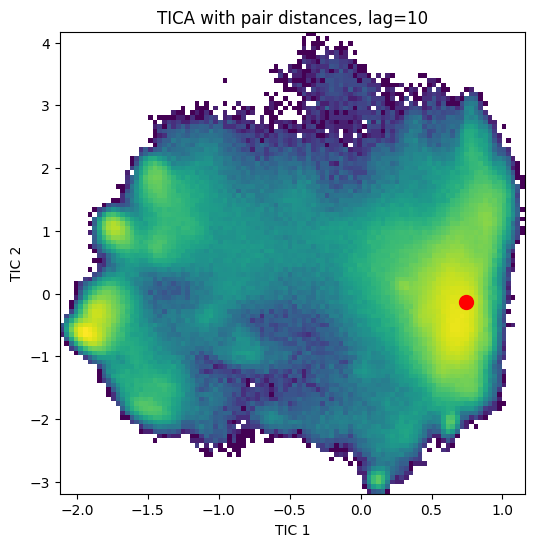

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/7 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/7 [00:00<?, ?it/s]

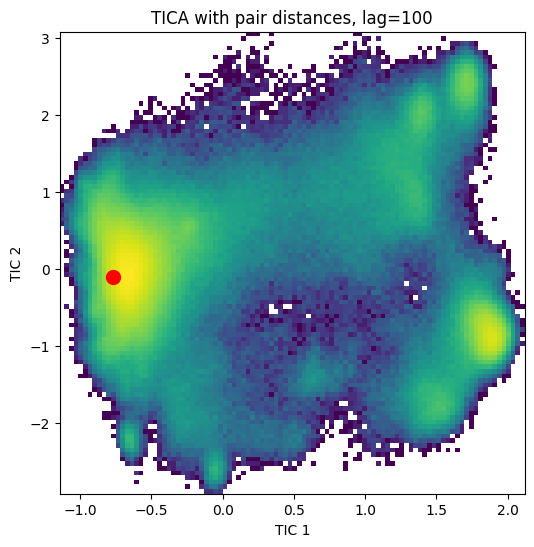

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/7 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/7 [00:00<?, ?it/s]

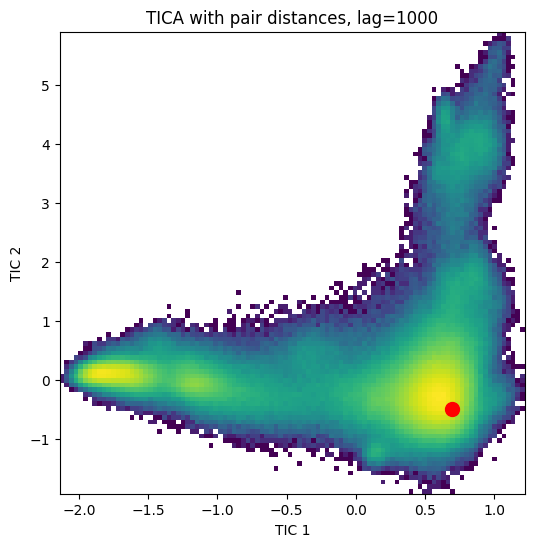

In [15]:
# TICA with pair distances
pdb_state = md.load(pdb_path)
pdb_state_ca_pair_distances, pdb_resid_pairs = md.compute_contacts(pdb_state, scheme="ca", contacts=ca_resid_pair, periodic=False)

for lag in (10, 100, 1000):
	tica_coord_path = f"../data/{molecule}/{molecule}_tica_coord_lag{lag}.npy"
	if os.path.exists(tica_coord_path):
		tica_data = np.load(tica_coord_path)
	else:
		tica_obj = pyemma.coordinates.tica(ca_pair_contacts, lag=lag, dim=2)
		tica_data = tica_obj.get_output()[0]
		np.save(tica_coord_path, tica_data)
	x = tica_data[:, 0]
	y = tica_data[:, 1]

	pdb_tica_data = tica_obj.transform(pdb_state_ca_pair_distances)
	pdb_tica_x = pdb_tica_data[:, 0]
	pdb_tica_y = pdb_tica_data[:, 1]

	# Plot
	fig = plt.figure(figsize=(6, 6))
	ax = fig.add_subplot(111)
	ax.hist2d(x, y, bins=100, norm=LogNorm())
	ax.scatter(pdb_tica_x, pdb_tica_y, color="red", s=100)
	ax.set_xlabel("TIC 1")
	ax.set_ylabel("TIC 2")
	plt.title(f"TICA with pair distances, lag={lag}")
	plt.savefig(f'../data/{molecule}/{molecule}_tica_model_lag{lag}.png')
	plt.show()
	plt.close()

	with open(f'../data/{molecule}/{molecule}_tica_model_lag{lag}.pkl', 'wb') as f:
		pickle.dump(tica_obj, f)

# Analysis

## States by RMSD

In [23]:
def rmsd_to_refpdb(
	traj: md.Trajectory,
	reference_traj: md.Trajectory,
	atom_type: str = "ca",
) -> np.ndarray:
	"""
	Generate binary labels for folded/unfolded states based on RMSD
	"""
	if atom_type == "ca":
		atom_indices = traj.topology.select("name CA")
	else:
		atom_indices = None
	
	rmsd = md.rmsd(
		target = traj,
		reference = reference_traj,
		atom_indices = atom_indices
	)
	return rmsd

### Folded

0.7495029


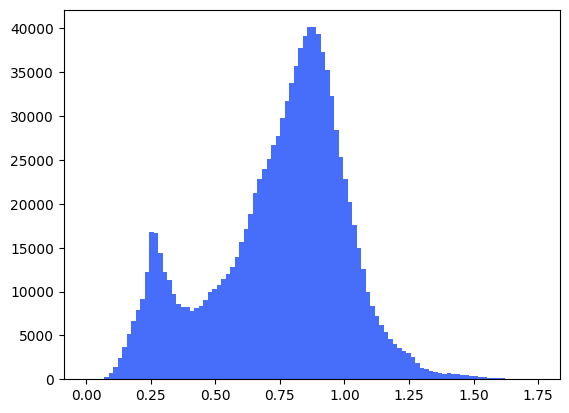

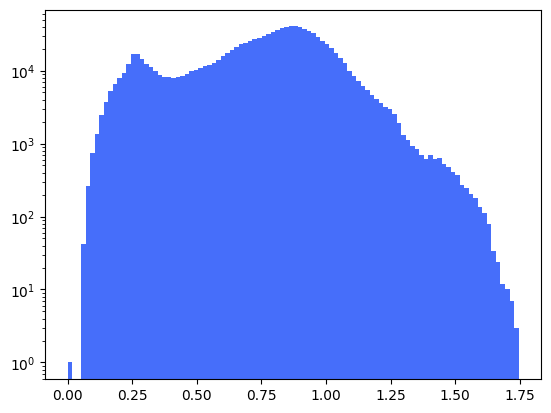

In [24]:
selected_frame = all_traj[189414]
rmsd_to_folded = rmsd_to_refpdb(
    traj = all_traj,
    reference_traj = selected_frame,
)

print(rmsd_to_folded.mean())
plt.hist(
    rmsd_to_folded,
    bins=100,
    # log=True,
    color=blue,
)
plt.show()

plt.hist(
    rmsd_to_folded,
    bins=100,
    log=True,
    color=blue,
)
plt.show()

In [25]:
dssp_selected = md.compute_dssp(selected_frame)
print(dssp_selected.shape)
print(dssp_selected[0])
view_selected = nv.show_mdtraj(selected_frame)
view_selected.add_representation("licorice", selection="protein")
view_selected

(1, 28)
['C' 'C' 'C' 'C' 'E' 'E' 'E' 'C' 'C' 'E' 'E' 'E' 'C' 'C' 'H' 'H' 'H' 'H'
 'H' 'H' 'H' 'H' 'H' 'H' 'C' 'C' 'C' 'C']


NGLWidget()

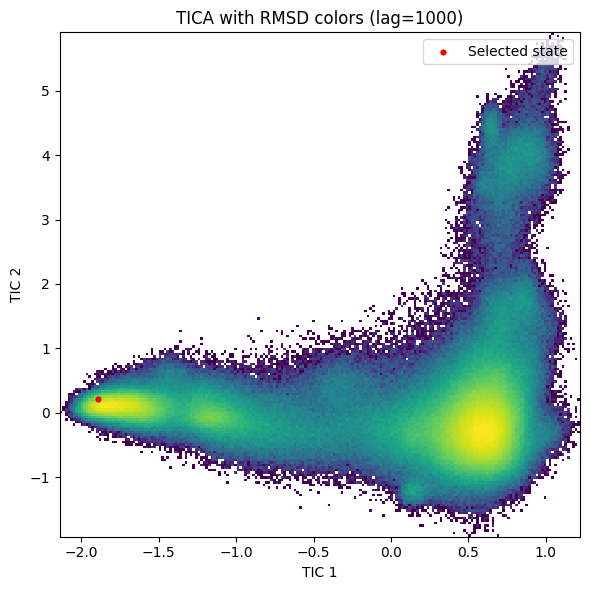

In [27]:
# pdb on TICA plot
lag = 1000

ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(all_traj.topology.residues), 2)]
)
selected_ca_pair_distances, resid_pairs = md.compute_contacts(
	selected_frame, scheme="ca", contacts=ca_resid_pair, periodic=False
)
tica_model_path = f"../data/{molecule}/{molecule}_tica_model_lag{lag}.pkl"
tica_model = pickle.load(open(tica_model_path, 'rb'))
tica_data_selected = tica_model.transform(selected_ca_pair_distances)
x_tica_selected = tica_data_selected[:, 0]
y_tica_selected = tica_data_selected[:, 1]

tica_coord_path = f"../data/{molecule}/{molecule}_tica_coord_lag{lag}.npy"
tica_data = np.load(tica_coord_path)
x = tica_data[:, 0]
y = tica_data[:, 1]

# Plot TICA with RMSD colors
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hist2d(x, y, bins=200, norm=LogNorm())
ax.scatter(
    x_tica_selected,
    y_tica_selected,
    c="red",
    s=20,
    edgecolors="k",
    linewidths=0,
    label="Selected state",
)
ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
ax.set_title(f"TICA with RMSD colors (lag={lag})")
ax.legend(loc="best")
plt.tight_layout()
plt.show()
plt.close()


In [ ]:
rmsd_threshold = 0.4
save_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein"

# selected_frame.save_pdb(
# 	f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/folded.pdb"
# )
# torch.save(
#     torch.from_numpy(rmsd_to_folded),
#     f"{save_dir}/{molecule}-{simulation_idx}-rmsd.pt"
# )
# torch.save(
#     torch.from_numpy(rmsd_to_folded < rmsd_threshold),
#     f"{save_dir}/{molecule}-{simulation_idx}-label-rmsd-folded.pt"
# )

### Unfolded

1.7408365


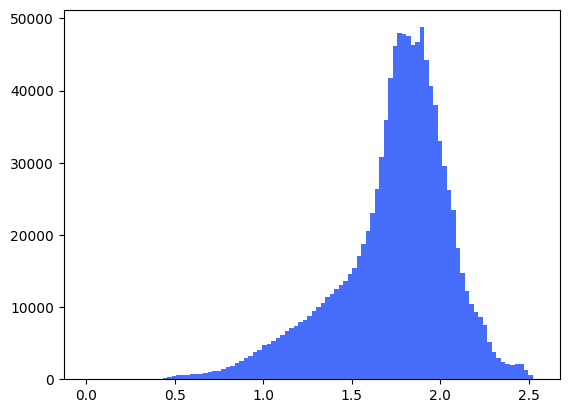

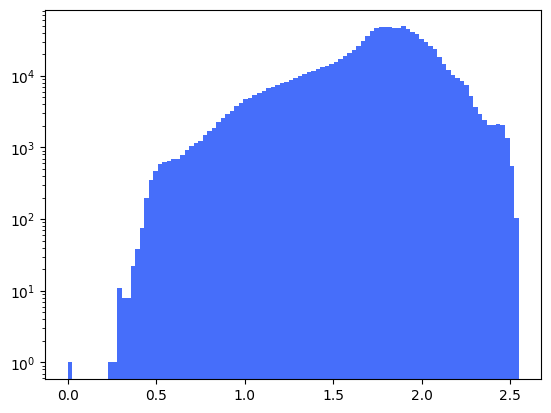

In [39]:
unfolded_selected_frame = all_traj[45541]
# unfolded_selected_frame = all_traj[45550]
unfolded_selected_rmsd = rmsd_to_refpdb(
    traj = all_traj,
    reference_traj = unfolded_selected_frame,
)

print(unfolded_selected_rmsd.mean())
plt.hist(
    unfolded_selected_rmsd,
    bins=100,
    # log=True,
    color=blue,
)
plt.show()

plt.hist(
    unfolded_selected_rmsd,
    bins=100,
    log=True,
    color=blue,
)
plt.show()

In [40]:
unfolded_dssp_selected = md.compute_dssp(unfolded_selected_frame)
print(unfolded_dssp_selected.shape)
print(unfolded_dssp_selected[0])
unfolded_selected_view = nv.show_mdtraj(unfolded_selected_frame)
unfolded_selected_view.add_representation("licorice", selection="protein")
unfolded_selected_view

(1, 28)
['C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C'
 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C']


NGLWidget()

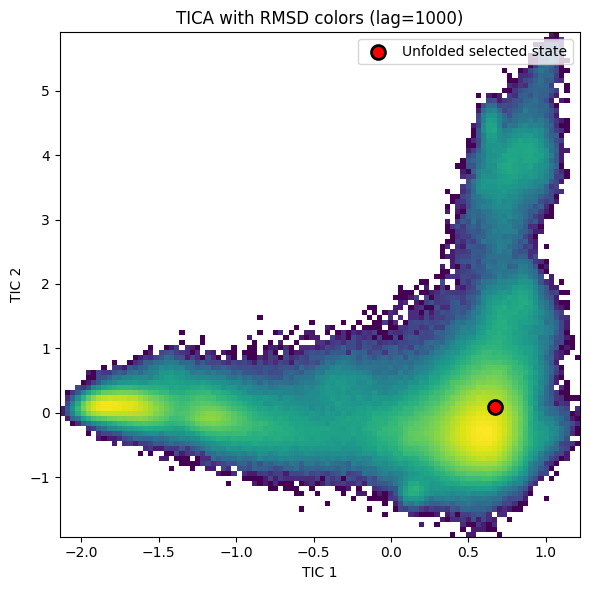

In [41]:
# pdb on TICA plot
lag = 1000

ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(all_traj.topology.residues), 2)]
)
unfolded_ca_pair_distances, resid_pairs = md.compute_contacts(
	unfolded_selected_frame, scheme="ca", contacts=ca_resid_pair, periodic=False
)
tica_model_path = f"../data/{molecule}/{molecule}_tica_model_lag{lag}.pkl"
tica_model = pickle.load(open(tica_model_path, 'rb'))
tica_data_selected = tica_model.transform(unfolded_ca_pair_distances)
x_tica_selected = tica_data_selected[:, 0]
y_tica_selected = tica_data_selected[:, 1]

tica_coord_path = f"../data/{molecule}/{molecule}_tica_coord_lag{lag}.npy"
tica_data = np.load(tica_coord_path)
x = tica_data[:, 0]
y = tica_data[:, 1]

# Plot TICA with RMSD colors
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hist2d(x, y, bins=100, norm=LogNorm())
ax.scatter(
    x_tica_selected,
    y_tica_selected,
    c="red",
    s=100,
    edgecolors="k",
    linewidths=2,
    label="Unfolded selected state",
)
ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
ax.set_title(f"TICA with RMSD colors (lag={lag})")
ax.legend(loc="best")
plt.tight_layout()
plt.show()
plt.close()


In [ ]:
save_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein"

unfolded_selected_frame.save_pdb(
	f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/unfolded.pdb"
)
# torch.save(
#     torch.from_numpy(unfolded_selected_rmsd),
#     f"{save_dir}/{molecule}-{simulation_idx}-rmsd_unfolded.pt"
# )

# Fractional Contacts

In [94]:
def compute_Q_fractional_contacts(
    traj: md.Trajectory,
    native: md.Trajectory,
    rc_native_nm: float = 0.8,     # native-contact cutoff on the native structure (≈8 Å)
    beta_nm_inv: float = 50.0,     # sharpness of switching (1/nm); 50 ~ 5/Å
    lambda_factor: float = 1.2,    # tolerance factor on native distance (typical 1.2)
    smooth_window_ns: float | None = None,  # e.g., 10.0 for 10 ns running average
    frame_dt_ps: float | None = None        # time per frame; required if smoothing in ns
):
    """
    Q(t) = (1/Nc) * sum_{(i,j) in native contacts} 1 / (1 + exp[ beta ( d_ij(t) - lambda * d_ij^0 ) ])
    where d_ij^0 is the native distance (nm). Returns per-frame Q (and smoothed if requested).
    """

    # -------- 1) Build CA-CA pairs and native contacts --------
    ca_idx = traj.topology.select('name CA')
    ca_pairs = np.array(list(combinations(ca_idx, 2)), dtype=int)

    # native distances for all CA pairs (in nm)
    d0_all, _ = md.compute_contacts(native[0], contacts=ca_pairs, scheme='ca')
    d0_all = d0_all[0]  # shape: (n_pairs,)

    # choose native-contact set: pairs whose native distance < rc_native_nm
    native_mask = d0_all < rc_native_nm
    if native_mask.sum() == 0:
        raise ValueError("No native contacts found with the given rc_native_nm.")
    contacts = ca_pairs[native_mask]
    d0 = d0_all[native_mask]  # shape: (Nc,)


    # -------- 2) Distances along the trajectory for those pairs --------
    d_t, _ = md.compute_contacts(traj, contacts=contacts, scheme='ca')  # shape: (T, Nc)

    # -------- 3) Fractional contacts per pair and frame, then average --------
    # switching: s_ij(t) = 1 / (1 + exp[beta*(d_ij(t) - lambda * d_ij^0)])
    s_ij = 1.0 / (1.0 + np.exp(beta_nm_inv * (d_t - (lambda_factor * d0)[None, :])))
    Q_t = s_ij.mean(axis=1)  # shape: (T,)

    # -------- 4) Optional running-average smoothing (e.g., 10 ns window) --------
    Q_smooth = None
    if smooth_window_ns is not None:
        if frame_dt_ps is None:
            raise ValueError("Provide frame_dt_ps (ps) to use smoothing in ns.")
        win_frames = max(1, int((smooth_window_ns * 1000.0) / frame_dt_ps))
        # simple centered moving average (valid region); pad to keep length T
        kernel = np.ones(win_frames) / win_frames
        Q_smooth = np.convolve(Q_t, kernel, mode='same')

    return (Q_t, Q_smooth, contacts, d0)

In [95]:
q, q_smooth, q_contacts, q_d0 = compute_Q_fractional_contacts(
	traj = all_traj,
	native = pdb_traj,
)

ValueError: contacts requests a residue that is not in the permitted range

In [ ]:
print(q.shape)
print(q_smooth.shape)
print(q_contacts.shape)
print(q_d0.shape)

NameError: name 'q' is not defined

In [43]:
# Handmade reaction coordinate Q

# Given values
dij_threshold = 1.0
beta_nm_inv = 10
pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/1FME/1FME.pdb"

# Compute alpha carbon pairs
native_traj = md.load(pdb_path)
ca_idx = native_traj.topology.select('name CA')
ca_resid_pair = np.array([
	(a.index, b.index)
	for a, b in combinations(list(native_traj.topology.residues), 2)
	if abs(a.index - b.index) >= 7
])
d0_ij_all, d0_ij_resid_pairs_all = md.compute_contacts(
    native_traj, contacts=ca_resid_pair, scheme='ca'
)
mask = d0_ij_all < dij_threshold
contact_pair = ca_resid_pair[mask[0]]

# Compute contact difference
dij, dij_resid_pairs = md.compute_contacts(
    all_traj, contacts=contact_pair, scheme='ca'
)
d0_ij, _ = md.compute_contacts(native_traj, contacts=contact_pair, scheme='ca')
contact_difference = dij - (d0_ij + 1)
native_contact = 1 / (1 + np.exp(beta_nm_inv * contact_difference))
native_contact_per_frame = native_contact.mean(axis=1)


[0.955877   0.8851347  0.9259862  ... 0.65372235 0.7014653  0.6309017 ]
(1114545,)
0.7043836


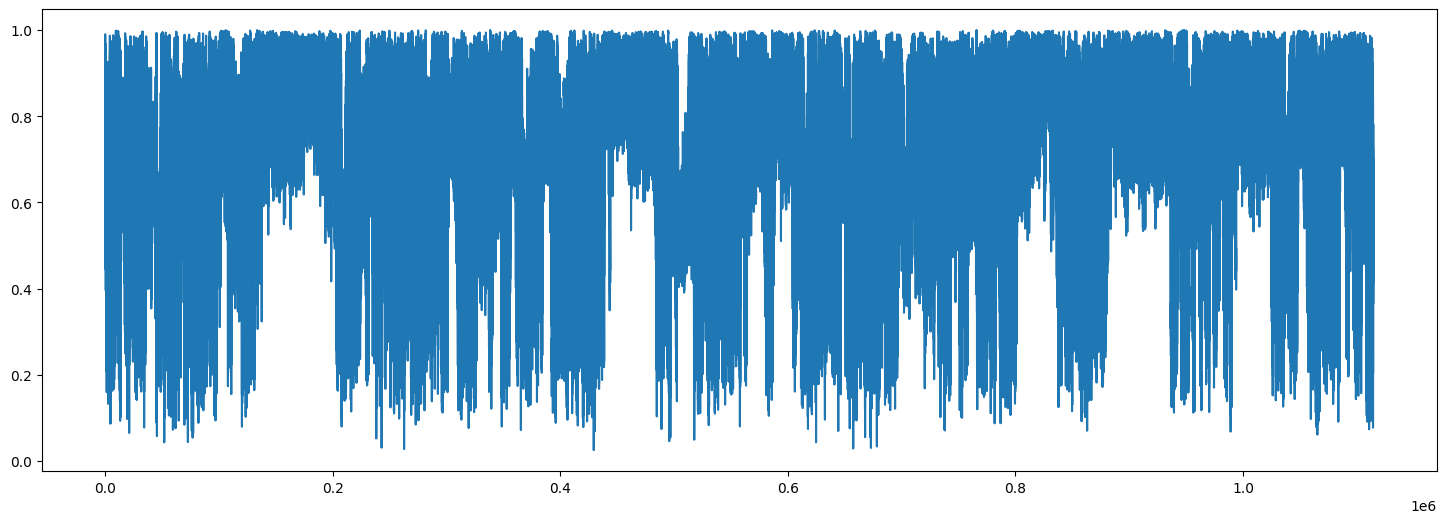

In [44]:
# Compute contact difference
native_contact_per_frame = native_contact.mean(axis=1)
print(native_contact_per_frame)
print(native_contact_per_frame.shape)
print(native_contact_per_frame.mean())
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)
ax.plot(native_contact_per_frame)

In [165]:
actual_native_contact_per_frame = actual_native_contact.sum(axis=1) / mask.sum(axis=1)
print(actual_native_contact_per_frame)
print(actual_native_contact_per_frame.shape)
print(actual_native_contact_per_frame.mean())

[0.99991935 0.99993064 0.99992274 ... 0.99991412 0.99986991 0.9999248 ]
(1114545,)
0.9999274880132276


# Conclusion